In [74]:
import pandas as pd
import numpy as np
import os
import itertools
import matplotlib.pyplot as plt
from matplotlib import rcParams, gridspec
from pandas.api.types import CategoricalDtype

import sklearn
from sklearn import model_selection
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn import metrics
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

In [75]:
import gc
gc.collect()

137

In [76]:
os.chdir("/Users/kelsey.huntzberry/Documents/Classes/Machine_Learning_Class/Data")
print(os.getcwd())

/Users/kelsey.huntzberry/Documents/Classes/Machine_Learning_Class/Data


In [77]:
# Read in Treatment Episode Data Set data
teds18 = pd.read_csv('tedsa_puf_2018.csv')

In [78]:
teds18.columns

Index(['ADMYR', 'CASEID', 'STFIPS', 'CBSA2010', 'EDUC', 'MARSTAT', 'SERVICES',
       'DETCRIM', 'NOPRIOR', 'PSOURCE', 'ARRESTS', 'EMPLOY', 'METHUSE',
       'PSYPROB', 'PREG', 'GENDER', 'VET', 'LIVARAG', 'DAYWAIT', 'DSMCRIT',
       'AGE', 'RACE', 'ETHNIC', 'DETNLF', 'PRIMINC', 'SUB1', 'SUB2', 'SUB3',
       'ROUTE1', 'ROUTE2', 'ROUTE3', 'FREQ1', 'FREQ2', 'FREQ3', 'FRSTUSE1',
       'FRSTUSE2', 'FRSTUSE3', 'HLTHINS', 'PRIMPAY', 'FREQ_ATND_SELF_HELP',
       'ALCFLG', 'COKEFLG', 'MARFLG', 'HERFLG', 'METHFLG', 'OPSYNFLG',
       'PCPFLG', 'HALLFLG', 'MTHAMFLG', 'AMPHFLG', 'STIMFLG', 'BENZFLG',
       'TRNQFLG', 'BARBFLG', 'SEDHPFLG', 'INHFLG', 'OTCFLG', 'OTHERFLG',
       'DIVISION', 'REGION', 'IDU', 'ALCDRUG'],
      dtype='object')

In [79]:
# Subset the data to just the 0/1 drug flag variables
flags = teds18.filter(regex='FLG$', axis = 1)

In [80]:
# Sum the flag variables to calculate the number of drugs recorded for each individual
NUMSUBS = flags.sum(axis=1)

In [81]:
# Concatenate flag variables back into the 2015-17 data
teds_wflgs = pd.concat([teds18, NUMSUBS], axis = 1)
teds_wflgs.rename(columns={0:'NUMSUBS'}, inplace = True)

In [82]:
# Remove rows where the first substance was "None"
teds_sm_temp = teds_wflgs[teds_wflgs.SUB1 != 1]
# Remove rows where number of prior treatments is NA (target variable)
teds_sm1 = teds_sm_temp[teds_sm_temp.NOPRIOR != -9]

In [83]:
# Select subset of columns
teds_sm = teds_sm1.loc[:,['CASEID','ADMYR','AGE','GENDER','RACE','ETHNIC','EDUC','EMPLOY','VET','LIVARAG',\
                          'STFIPS','CBSA2010','DIVISION','REGION','SERVICES','PSOURCE','NOPRIOR','ARRESTS','ROUTE1','FRSTUSE1','FREQ1', \
                          'ROUTE2','FRSTUSE2', 'FREQ2','ROUTE3','FRSTUSE3','FREQ3','NUMSUBS','METHUSE','ALCFLG','PSYPROB', \
                          'COKEFLG','MARFLG','HERFLG','METHFLG','OPSYNFLG','PCPFLG','HALLFLG','MTHAMFLG','AMPHFLG','STIMFLG', \
                          'BENZFLG','TRNQFLG','BARBFLG','SEDHPFLG','INHFLG','OTCFLG','OTHERFLG']]

In [84]:
# Recode age group variable
def age_groups(series):
    if series == 1:
        return '12_14_years'
    elif series == 2:
        return '15_17_years'
    elif series == 3:
        return '18_20_years'
    elif series == 4:
        return '21_24_years'
    elif series == 5:
        return '25_29_years'
    elif series == 6:
        return '30_34_years'
    elif series == 7:
        return '35_39_years'
    elif series == 8:
        return '40_44_years'
    elif series == 9:
        return '45_49_years'
    elif series == 10:
        return '50_54_years'
    elif series == 11:
        return '55_64_years'
    elif series == 12:
        return '65_plus_years'
    
teds_sm1.loc[:, 'age_group'] = teds_sm1.AGE.apply(age_groups)

# Change variable to an ordered factor
teds_sm1.loc[:, 'age_group'] = pd.Categorical(teds_sm1['age_group'], categories = ['12_14_years', '15_17_years', '18_20_years',
                                                                                   '21_24_years', '25_29_years', '30_34_years',
                                                                                   '35_39_years', '40_44_years', '45_49_years',
                                                                                   '50_54_years', '55_64_years', '65_plus_years'], ordered = True)

# Change variable to an ordered factor with values as numbers
labels, unique = pd.factorize(teds_sm1.loc[:, 'age_group'], sort = True)
teds_sm1.loc[:, 'age_group'] = labels

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [85]:
# Recode gender variable
def gen_rc(series):
    if series == 1:
        return 0
    elif series == 2:
        return 1
    
teds_sm1.loc[:, 'gender'] = teds_sm1.GENDER.apply(gen_rc)

In [86]:
# Recode methadone variable
def methadone_rc(series):
    if series == 1:
        return 1
    elif series == 2:
        return 0
    
teds_sm1.loc[:, 'methadone_use'] = teds_sm1.METHUSE.apply(methadone_rc)

In [87]:
# Education recode
def educ_rc(series):
    if series == 1:
        return 'No_Schooling'
    elif series == 2:
        return 'Grades_9_to_11'
    elif series == 3:
        return 'Grades_12_or_GED'
    elif series == 4:
        return 'College_1_to_3_years'
    elif series == 5:
        return 'College_4_or_more_years'

teds_sm1.loc[:, 'educ'] = teds_sm1.EDUC.apply(educ_rc)

# Change variable to an ordered factor
teds_sm1.loc[:, 'educ'] = pd.Categorical(teds_sm1['educ'], categories = ['No_Schooling', 'Grades_9_to_11', 'Grades_12_or_GED',
                                                                         'College_1_to_3_years', 'College_4_or_more_years'], ordered = True)

# Change variable to an ordered factor with values as numbers
labels, unique = pd.factorize(teds_sm1.loc[:, 'educ'], sort = True)
teds_sm1.loc[:, 'educ'] = labels

In [88]:
# Record race variable
def race_rc(series):
    if series == 1:
        return 'Alaska_Native'
    elif series == 2:
        return 'American_Indian'
    elif series == 3 or series == 9:
        return 'Hawaiian_Pacific_Islander'
    elif series == 4:
        return 'Black'
    elif series == 5:
        return 'White'
    elif series == 6:
        return 'Asian'
    elif series == 7:
        return 'Other_race'
    elif series == 8:
        return 'Two_or_more_races'
    
teds_sm1.loc[:, 'race'] = teds_sm1.RACE.apply(race_rc)

In [89]:
# Recode ethnicity variable
def ethnic_rc(series):
    if (series >= 1 or series <= 3) or series == 5:
        return 1
    elif series == 4:
        return 0
    
teds_sm1.loc[:, 'ethnic'] = teds_sm1.ETHNIC.apply(ethnic_rc)

In [90]:
# Recode service setting variable
def servseta_rc(series):
    if series == 1 or series == 2:
        return 'Detox'
    elif series >= 3 and series <= 5:
        return 'Rehab_Residential'
    elif series >= 6 and series <= 8:
        return 'Ambulatory'

teds_sm1.loc[:, 'services'] = teds_sm1.SERVICES.apply(servseta_rc)

In [91]:
# Recode marital status variable
def marstat_rc(series):
    if series == 1:
        return 'Never_Married'
    elif series == 2:
        return 'Married'
    elif series == 3:
        return 'Separated'
    elif series == 4:
        return 'Divorced_or_Widowed'

teds_sm1.loc[:, 'marstat'] = teds_sm1.MARSTAT.apply(marstat_rc)

In [92]:
# Recode employment status variable
def employ_rc(series):
    if series == 1:
        return 'Full_time'
    elif series == 2:
        return 'Part_time'
    elif series == 3:
        return 'Unemployed'
    elif series == 4:
        return 'Not_in_labor_force'
    
teds_sm1.loc[:, 'employ'] = teds_sm1.EMPLOY.apply(employ_rc)

In [93]:
# Recode veteran variable
def vet_rc(series):
    if series == 1:
        return 1
    elif series == 2:
        return 0
    
teds_sm1.loc[:, 'vet'] = teds_sm1.VET.apply(vet_rc)

In [94]:
# Recode living arrangement variable
def livarag_rc(series):
    if series == 1:
        return 'Homeless'
    elif series == 2:
        return 'Dependent_Living'
    elif series == 3:
        return 'Independent_Living'

teds_sm1.loc[:, 'livarag'] = teds_sm1.LIVARAG.apply(livarag_rc)

In [95]:
# Recode arrests variable
def arrests_rc(series):
    if series == 0:
        return 'None'
    elif series == 1:
        return 'Once'
    elif series == 2:
        return 'Two_or_more_times'
    
teds_sm1.loc[:, 'arrests'] = teds_sm1.ARRESTS.apply(arrests_rc)

# Change variable to an ordered factor variable
teds_sm1.loc[:, 'arrests'] = pd.Categorical(teds_sm1['arrests'], categories = ['None', 'Once',
                                                                              '2 or more times'],
                                           ordered = True)

# Change variable to an ordered factor with values as numbers
labels, unique = pd.factorize(teds_sm1.loc[:, 'arrests'], sort = True)
teds_sm1.loc[:, 'arrests'] = labels

In [96]:
# Recode division variable
def division_rc(series):
    if series == 0:
        return 'US_Territories'
    elif series == 1:
        return 'New_England'
    elif series == 2:
        return 'Mid_Atlantic'
    elif series == 3:
        return 'East_North_Central'
    elif series == 4:
        return 'West_North_Central'
    elif series == 5:
        return 'South_Atlantic'
    elif series == 6:
        return 'East_South_Central'
    elif series == 7:
        return 'West_South_Central'
    elif series == 8:
        return 'Mountain'
    elif series == 9:
        return 'Pacific'
    
teds_sm1.loc[:, 'division'] = teds_sm1.DIVISION.apply(division_rc)

In [97]:
# Recode referral source variable
def psource_rc(series):
    if series == 1:
        return 'Self_referral'
    elif series == 2:
        return 'Alcohol_Drug_Care_Professional'
    elif series == 3:
        return 'Other_Health_Care_Professional'
    elif series == 4:
        return 'School_Referral'
    elif series == 5:
        return 'Employer_Referral'
    elif series == 6:
        return 'Community_Referral'
    elif series == 7:
        return 'Court_Referral'
    
teds_sm1.loc[:, 'psource'] = teds_sm1.PSOURCE.apply(psource_rc)

In [98]:
# Recode number of prior treatment encounters
def noprior_rc(series):
    if series == 0:
        return 0
    elif series >= 1:
        return 1
    
teds_sm1.loc[:, 'noprior'] = teds_sm1.NOPRIOR.apply(noprior_rc)

In [99]:
# Recode mental illness variable
def psyprob_rc(series):
    if series == 1:
        return 1
    elif series == 2:
        return 0
    
teds_sm1.loc[:, 'psyprob'] = teds_sm1.PSYPROB.apply(psyprob_rc)

In [100]:
# Recode number of substances variable
def numsubs_rc(series):
    if series == 0:
        return 'Zero_substances'
    elif series == 1:
        return 'One_substance'
    elif series == 2:
        return 'Two_substances'
    elif series == 3:
        return 'Three_substances'
    
teds_sm1.loc[:, 'numsubs'] = teds_sm1.NUMSUBS.apply(numsubs_rc)

# Change first use into an ordered factor
teds_sm1.loc[:, 'numsubs'] = pd.Categorical(teds_sm1['numsubs'], categories = ['Zero substances', 'One substance',
                                                                               'Two substances', "Three substances"], ordered = True)

# Convert year to factor with numeric value
labels, unique = pd.factorize(teds_sm1.loc[:, 'numsubs'], sort = True)
teds_sm1.loc[:, 'numsubs'] = labels

In [101]:
# Taking age of first use from up to 3 substances in system and creating a flag if present
def first_age_recode(column1, column2, column3):
    if column1 == 1 or column2 == 1 or column3 == 1:
        return '11_years_and_under'
    elif column1 == 2 or column2 == 2 or column3 == 2:
        return '12_14_years'
    elif column1 == 3 or column2 == 3 or column3 == 3:
        return '15_17_years'
    elif column1 == 4 or column2 == 4 or column3 == 4:
        return '18_20_years'
    elif column1 == 5 or column2 == 5 or column3 == 5:
        return '21_24_years'
    elif column1 == 6 or column2 == 6 or column3 == 6:
        return '25_29_years'
    elif column1 == 7 or column2 == 7 or column3 == 7:
        return '30_years_older'

teds_sm1.loc[:, 'frstuse'] = teds_sm1.apply(lambda x: first_age_recode(x.FRSTUSE1, x.FRSTUSE2, x.FRSTUSE3), axis=1)

# Change first use into an ordered factor
teds_sm1.loc[:, 'frstuse'] = pd.Categorical(teds_sm1['frstuse'], categories = ['11_years_and_under', '12_14_years', '15_17_years',
                                                                               '18_20_years', '21_24_years',
                                                                               '25_29_years', '30_years_older'], ordered = True)
# Convert year to factor with numeric value
labels, unique = pd.factorize(teds_sm1.loc[:, 'frstuse'], sort = True)
teds_sm1.loc[:, 'frstuse'] = labels

In [102]:
# Taking frequency of use from up to 3 substances in system and creating a flag if present
def freq_recode(column1, column2, column3):
    if (column1 == 1 and column2 == 1 and column3 == 1):
        return 'No_Use_Past_Month'
    elif (column1 == 3 or column2 == 3 or column3 == 3):
        return 'Daily_Use'
    elif (column1 == 2 or column2 == 2 or column3 == 2):
        return 'Some_Use'
    elif (column1 == 1 or column2 == 1 or column3 == 1):
        return 'No_Use_Past_Month'

teds_sm1.loc[:, 'freq_use'] = teds_sm1.apply(lambda x: freq_recode(x.FREQ1, x.FREQ2, x.FREQ3), axis=1)

# Change first use into an ordered factor
teds_sm1.loc[:, 'freq_use'] = pd.Categorical(teds_sm1['freq_use'], categories = ['No_Use_Past_Month', 'Daily_Use', 'Some_Use'], ordered = True)
# Convert year to factor with numeric value
labels, unique = pd.factorize(teds_sm1.loc[:, 'freq_use'], sort = True)
teds_sm1.loc[:, 'freq_use'] = labels

In [103]:
# Taking administration method from up to 3 substances in system and creating a flag if present
def oral_recode(column1, column2, column3):
    if (column1 == 1 and column1 != None) or (column2 == 1 and column2 != None) or (column3 == 1 and column3 != None):
        return 1
    elif (column1 > 1 and column1 != None) or (column2 > 1 and column2 != None) or (column3 > 1 and column3 != None):
        return 0

teds_sm1.loc[:, 'oral_drug_use'] = teds_sm1.apply(lambda x: oral_recode(x.ROUTE1, x.ROUTE2, x.ROUTE3), axis=1)

def smoking_recode(column1, column2, column3):
    if (column1 == 2 and column1 != None) or (column2 == 2 and column2 != None) or (column3 == 2 and column3 != None):
        return 1
    elif (column1 > 0 and column1 != None) or (column2 > 0 and column2 != None) or (column3 > 0 and column3 != None):
        return 0

teds_sm1.loc[:, 'smoking_drug_use'] = teds_sm1.apply(lambda x: smoking_recode(x.ROUTE1, x.ROUTE2, x.ROUTE3), axis=1)

def inhalation_recode(column1, column2, column3):
    if (column1 == 3 and column1 != None) or (column2 == 3 and column2 != None) or (column3 == 3 and column3 != None):
        return 1
    elif (column1 > 0 and column1 != None) or (column2 > 0 and column2 != None) or (column3 > 0 and column3 != None):
        return 0
    
teds_sm1.loc[:, 'inhale_drug_use'] = teds_sm1.apply(lambda x: inhalation_recode(x.ROUTE1, x.ROUTE2, x.ROUTE3), axis=1)
    
def injection_recode(column1, column2, column3):
    if (column1 == 4 and column1 != None) or (column2 == 4 and column2 != None) or (column3 == 4 and column3 != None):
        return 1
    elif (column1 > 0 and column1 != None) or (column2 > 0 and column2 != None) or (column3 > 0 and column3 != None):
        return 0
    
teds_sm1.loc[:, 'injection_drug_use'] = teds_sm1.apply(lambda x: injection_recode(x.ROUTE1, x.ROUTE2, x.ROUTE3), axis=1)

In [127]:
# Subset to fewer variables, mostly dropping those with many missing values
teds_clean = teds_sm1.drop(['ADMYR', 'CASEID', 'STFIPS', 'CBSA2010', 'EDUC', 'MARSTAT', 'SERVICES',
                            'DETCRIM', 'NOPRIOR', 'PSOURCE', 'ARRESTS', 'EMPLOY', 'METHUSE',
                            'PSYPROB', 'PREG', 'GENDER', 'VET', 'LIVARAG', 'DAYWAIT', 'DSMCRIT',
                            'AGE', 'RACE', 'ETHNIC', 'DETNLF', 'PRIMINC', 'SUB1', 'SUB2', 'SUB3',
                            'ROUTE1', 'ROUTE2', 'ROUTE3', 'FREQ1', 'FREQ2', 'FREQ3', 'FRSTUSE1',
                            'FRSTUSE2', 'FRSTUSE3', 'HLTHINS', 'PRIMPAY', 'FREQ_ATND_SELF_HELP', 
                            'IDU','REGION'], axis = 1)

In [128]:
teds_clean.columns

Index(['ALCFLG', 'COKEFLG', 'MARFLG', 'HERFLG', 'METHFLG', 'OPSYNFLG',
       'PCPFLG', 'HALLFLG', 'MTHAMFLG', 'AMPHFLG', 'STIMFLG', 'BENZFLG',
       'TRNQFLG', 'BARBFLG', 'SEDHPFLG', 'INHFLG', 'OTCFLG', 'OTHERFLG',
       'DIVISION', 'ALCDRUG', 'NUMSUBS', 'age_group', 'gender',
       'methadone_use', 'educ', 'race', 'ethnic', 'services', 'marstat',
       'employ', 'vet', 'livarag', 'arrests', 'division', 'psource', 'noprior',
       'psyprob', 'numsubs', 'frstuse', 'freq_use', 'oral_drug_use',
       'smoking_drug_use', 'inhale_drug_use', 'injection_drug_use'],
      dtype='object')

In [129]:
teds_clean.employ.value_counts()

Unemployed            577217
Not_in_labor_force    545991
Full_time             280470
Part_time             111805
Name: employ, dtype: int64

In [130]:
# Subset data for easy analysis
teds_clean = teds_clean.sample(n = 200000, random_state=16)

In [131]:
teds_clean.columns

Index(['ALCFLG', 'COKEFLG', 'MARFLG', 'HERFLG', 'METHFLG', 'OPSYNFLG',
       'PCPFLG', 'HALLFLG', 'MTHAMFLG', 'AMPHFLG', 'STIMFLG', 'BENZFLG',
       'TRNQFLG', 'BARBFLG', 'SEDHPFLG', 'INHFLG', 'OTCFLG', 'OTHERFLG',
       'DIVISION', 'ALCDRUG', 'NUMSUBS', 'age_group', 'gender',
       'methadone_use', 'educ', 'race', 'ethnic', 'services', 'marstat',
       'employ', 'vet', 'livarag', 'arrests', 'division', 'psource', 'noprior',
       'psyprob', 'numsubs', 'frstuse', 'freq_use', 'oral_drug_use',
       'smoking_drug_use', 'inhale_drug_use', 'injection_drug_use'],
      dtype='object')

In [109]:
#teds_clean.to_csv("teds_data_small.csv",index=False)
teds_clean = pd.read_csv("teds_data_small.csv")

In [132]:
# Create dummy variables for unordered categorical variables
# Need to make sure at least one category from each variable is removed during feature selection
teds2018 = pd.get_dummies(teds_clean, columns=['race','psource','division','ethnic','services','marstat','employ',
                                               'livarag'])

In [111]:
teds2018.columns

Index(['ALCFLG', 'COKEFLG', 'MARFLG', 'HERFLG', 'METHFLG', 'OPSYNFLG',
       'PCPFLG', 'HALLFLG', 'MTHAMFLG', 'AMPHFLG', 'STIMFLG', 'BENZFLG',
       'TRNQFLG', 'BARBFLG', 'SEDHPFLG', 'INHFLG', 'OTCFLG', 'OTHERFLG',
       'DIVISION', 'ALCDRUG', 'NUMSUBS', 'age_group', 'gender',
       'methadone_use', 'educ', 'vet', 'arrests', 'noprior', 'psyprob',
       'numsubs', 'frstuse', 'freq_use', 'oral_drug_use', 'smoking_drug_use',
       'inhale_drug_use', 'injection_drug_use', 'race_Alaska_Native',
       'race_American_Indian', 'race_Asian', 'race_Black',
       'race_Hawaiian_Pacific_Islander', 'race_Other_race',
       'race_Two_or_more_races', 'race_White',
       'psource_Alcohol_Drug_Care_Professional', 'psource_Community_Referral',
       'psource_Court_Referral', 'psource_Employer_Referral',
       'psource_Other_Health_Care_Professional', 'psource_School_Referral',
       'psource_Self_referral', 'division_East_North_Central',
       'division_East_South_Central', 'division_Mid_A

In [112]:
teds2018

,ALCFLG,COKEFLG,MARFLG,HERFLG,METHFLG,OPSYNFLG,PCPFLG,HALLFLG,MTHAMFLG,AMPHFLG,...,marstat_Married,marstat_Never_Married,marstat_Separated,employ_Full_time,employ_Not_in_labor_force,employ_Part_time,employ_Unemployed,livarag_Dependent_Living,livarag_Homeless,livarag_Independent_Living
1345611,1,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,1
332688,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
376764,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
41708,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1483754,0,0,1,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1838556,0,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
1609196,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,1
1168347,1,0,1,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,1
226932,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,1,0,0


In [140]:
# Drop response variable and year since only 2017 will be used in final modeling
data = teds2018.drop(columns = ['noprior'])
# Recording column names to object for later use in feature selection
columns = data.columns
# Create data frame with just the response variable
response = teds2018.loc[:,['noprior']]

In [148]:
# Change response and predictor data frames to numpy arrays
data_imp_np = np.array(data)
response_np = np.array(response)

In [149]:
# Create holdout data set and keep remaining 80% in one data frame
# Used stratefied random sampling because there was class imbalance
sss = StratifiedShuffleSplit(n_splits = 2, test_size=0.2, random_state=0)

sss.get_n_splits(data_imp_np, response_np)

for train_index, test_index in sss.split(data_imp_np, response_np):
    x_train_temp, x_test = data_imp_np[train_index], data_imp_np[test_index]
    y_train_temp, y_test = response_np[train_index], response_np[test_index]

# Split the remaining data into a training and validation data set (50% and 30% respectively)
sss_valid = StratifiedShuffleSplit(n_splits = 2, test_size = 0.3, random_state = 10)  
    
for train_index, test_index in sss_valid.split(x_train_temp, y_train_temp):
    x_train, x_validation = x_train_temp[train_index], x_train_temp[test_index]
    y_train, y_validation = y_train_temp[train_index], y_train_temp[test_index]

    
x_train = np.array(x_train)
y_train = np.array(y_train)
x_validation = np.array(x_validation)
y_validation = np.array(y_validation)
x_test = np.array(x_test)
y_test = np.array(y_test)

In [153]:
# Impute missing data with mode
# Will put this in a pipeline when we choose our final model
simple_imputer = SimpleImputer(strategy = 'most_frequent')
my_imputer = simple_imputer.fit(x_train)
x_train = my_imputer.transform(x_train)
x_validation = my_imputer.transform(x_validation)

In [154]:
# Example of how you use k-fold cross validation (by default for classification models it used stratified k-fold cross validation)
log_reg_kfold_cv = LogisticRegression()
accuracy_scores = cross_val_score(log_reg_kfold_cv, x_train, y_train, cv=5, scoring='accuracy')
accuracy_scores.mean()

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_

0.7034106893362863

In [9]:
# Create user-defined function to create formatted confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("\nNormalized confusion matrix")
    else:
        print('\nConfusion matrix, without normalization')

    print ()

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize = 15)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=20, fontsize = 14)
    plt.yticks(tick_marks, classes, fontsize = 14)

    plt.tight_layout()
    plt.ylabel('True label', fontsize = 14)
    plt.xlabel('Predicted label', fontsize = 14)


In [10]:
# Run logistic regression model as a baseline
logreg_model = LogisticRegression()
logreg_model.fit(x_train, np.ravel(y_train, order='C'))
valid_predict_logreg = logreg_model.predict(x_validation)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


              precision    recall  f1-score   support

           0       0.67      0.53      0.59     19409
           1       0.72      0.82      0.77     28591

    accuracy                           0.70     48000
   macro avg       0.69      0.67      0.68     48000
weighted avg       0.70      0.70      0.69     48000


Normalized confusion matrix



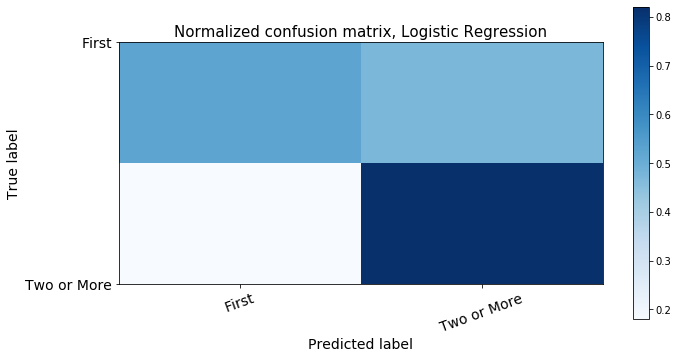

In [11]:
# Print classification report
print(classification_report(y_validation, valid_predict_logreg))

# Assign classes
class_names = ['First', 'Two or More']

# Compute confusion matrix
cnf_matrix_logreg = confusion_matrix(y_validation, valid_predict_logreg)
np.set_printoptions(precision=2) # set NumPy to 2 decimal places

# Plot normalized confusion matrix
plt.figure(figsize=(10,5))
plot_confusion_matrix(cnf_matrix_logreg, classes=class_names, normalize=True,
                      title='Normalized confusion matrix, Logistic Regression')

# Results: Accuracy is 68%, but very bad accuracy for identifying first admission patients

In [12]:
# Lasso regression grid search across multiple penalties
penalties = [0.2, 0.5, 0.7, 0.9]

results_lasso = pd.DataFrame([])

for i in range(0,4):
    
    print(i)
    
    c_value = penalties[i]

    lasso_model = LogisticRegression(penalty = 'l1', C = c_value)

    lasso_model.fit(x_train, np.ravel(y_train, order='C'))

    valid_predict_lasso = lasso_model.predict(x_validation)

    class_report = pd.DataFrame(classification_report(y_validation, valid_predict_lasso, 
                                                      output_dict = True)).iloc[:, 0:2]

    class_report = class_report.T

    class_report.loc[:, 'accuracy'] = pd.DataFrame(classification_report(y_validation, valid_predict_lasso, 
                                                                         output_dict = True)).iloc[1, 2]
    class_report.loc[:, 'c'] = c_value
    class_report.loc[:, 'model'] = 'Lasso Regression'
    class_report.loc[:, 'model_value'] = ['First Treatment Episode', '2+ Treatment Episodes']

    results_lasso = pd.concat([results_lasso, class_report], axis = 0)

# Results: Results were little better than logistic regression and varied little when penalty was changed

0


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [13]:
results_lasso

,precision,recall,f1-score,support,accuracy,c,model,model_value
0,0.666645,0.526405,0.588283,19409.0,0.702063,0.2,Lasso Regression,First Treatment Episode
1,0.718675,0.821307,0.766571,28591.0,0.702063,0.2,Lasso Regression,2+ Treatment Episodes
0,0.666515,0.527024,0.588618,19409.0,0.702125,0.5,Lasso Regression,First Treatment Episode
1,0.718862,0.820993,0.766540,28591.0,0.702125,0.5,Lasso Regression,2+ Treatment Episodes
0,0.666428,0.527024,0.588584,19409.0,0.702083,0.7,Lasso Regression,First Treatment Episode
1,0.718845,0.820923,0.766500,28591.0,0.702083,0.7,Lasso Regression,2+ Treatment Episodes
0,0.666450,0.527281,0.588753,19409.0,0.702146,0.9,Lasso Regression,First Treatment Episode
1,0.718938,0.820853,0.766522,28591.0,0.702146,0.9,Lasso Regression,2+ Treatment Episodes


In [71]:
# Ridge regression grid search across multiple penalties
penalties = [0.2, 0.5, 0.7, 0.9]

results_ridge = pd.DataFrame([])

for i in range(0,4):
    
    print(i)
    
    c_value = penalties[i]

    ridge_model = LogisticRegression(penalty = 'l2', C = c_value)

    ridge_model.fit(x_train, np.ravel(y_train, order='C'))

    valid_predict_ridge = ridge_model.predict(x_validation)

    class_report = pd.DataFrame(classification_report(y_validation, valid_predict_ridge, output_dict = True)).iloc[:, 0:2]

    class_report = class_report.T

    class_report.loc[:, 'accuracy'] = pd.DataFrame(classification_report(y_validation, valid_predict_ridge, output_dict = True)).iloc[1, 2]
    class_report.loc[:, 'c'] = c_value
    class_report.loc[:, 'model'] = 'Ridge Regression'
    class_report.loc[:, 'model_value'] = ['First Treatment Episode', '2+ Treatment Episodes']

    results_ridge = pd.concat([results_ridge, class_report], axis = 0)
    
# Results: Results were little better than logistic regression and varied little when penalty was changed

0


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [73]:
results_ridge

,precision,recall,f1-score,support,accuracy,c,model,model_value
0,0.671368,0.520213,0.586203,162966.0,0.704886,0.2,Ridge Regression,First Treatment Episode
1,0.720041,0.828942,0.770663,242596.0,0.704886,0.2,Ridge Regression,2+ Treatment Episodes
0,0.671340,0.520133,0.586142,162966.0,0.704856,0.5,Ridge Regression,First Treatment Episode
1,0.720008,0.828946,0.770646,242596.0,0.704856,0.5,Ridge Regression,2+ Treatment Episodes
0,0.671342,0.520127,0.586139,162966.0,0.704856,0.7,Ridge Regression,First Treatment Episode
1,0.720007,0.828950,0.770647,242596.0,0.704856,0.7,Ridge Regression,2+ Treatment Episodes
0,0.671334,0.520108,0.586124,162966.0,0.704849,0.9,Ridge Regression,First Treatment Episode
1,0.719999,0.828950,0.770643,242596.0,0.704849,0.9,Ridge Regression,2+ Treatment Episodes


In [74]:
lasso_model = LogisticRegression(penalty = 'l1', C = 0.2)
lasso_model.fit(x_train, np.ravel(y_train, order='C'))
valid_predict_lasso = lasso_model.predict(x_validation)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [75]:
lasso_coefs = pd.DataFrame(columns, list(lasso_model.coef_)).reset_index()
lasso_coefs.columns = ['coefficients','features']
lasso_coefs = lasso_coefs.sort_values(by='coefficients', ascending=False)
lasso_coefs

,coefficients,features
35,1.678579,race_Alaska_Native
6,0.665620,PCPFLG
43,0.515259,psource_Alcohol_Drug_Care_Professional
3,0.460193,HERFLG
4,0.436749,METHFLG
...,...,...
57,-0.692815,division_US_Territories
59,-0.703937,division_West_South_Central
56,-0.705250,division_South_Atlantic
51,-0.741591,division_East_South_Central


In [76]:
ridge_model = LogisticRegression(penalty = 'l2', C = 0.2)
ridge_model.fit(x_train, np.ravel(y_train, order='C'))
valid_predict_ridge = ridge_model.predict(x_validation)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [77]:
ridge_coefs = pd.DataFrame(columns, list(ridge_model.coef_)).reset_index()
ridge_coefs.columns = ['coefficients','features']
ridge_coefs = ridge_coefs.sort_values(by='coefficients', ascending=False)
ridge_coefs

,coefficients,features
35,1.667012,race_Alaska_Native
53,0.996623,division_Mountain
58,0.703668,division_West_North_Central
6,0.547479,PCPFLG
43,0.513665,psource_Alcohol_Drug_Care_Professional
...,...,...
46,-0.551260,psource_Employer_Referral
68,-0.568989,employ_Full_time
10,-0.570661,STIMFLG
57,-0.795161,division_US_Territories


In [78]:
# Run default gradient boosted trees model to get baseline accuracy and feature importances
gbt_model = GradientBoostingClassifier(random_state=75)
gbt_model.fit(x_train, np.ravel(y_train, order='C'))
valid_predict_gbt = gbt_model.predict(x_validation)

KeyboardInterrupt: 

In [ ]:
# Evaluation metrics and feature importances to narrow down variables I need
print(classification_report(y_validation, valid_predict_gbt))

# Print feature importances to subset data set to more important variables
print(pd.DataFrame({'features': data_imputed.columns,
                    'importances': gbt_model.feature_importances_}).sort_values(['importances'], ascending = 0))

class_names = ['First', 'Two or More']

# Compute confusion matrix
cnf_matrix_gbt = confusion_matrix(y_validation, valid_predict_gbt)
np.set_printoptions(precision=2) # set NumPy to 2 decimal places

# Plot normalized confusion matrix
plt.figure(figsize=(10,5))
plot_confusion_matrix(cnf_matrix_gbt, classes=class_names, normalize=True,
                      title='Normalized confusion matrix, Gradient Boosted Trees')

In [ ]:
rf_model = RandomForestClassifier(random_state=75)
rf_model.fit(x_train, np.ravel(y_train, order='C'))
valid_predict_rf = rf_model_default.predict(x_validation)

In [ ]:
# Evaluation metrics and feature importances to narrow down variables I need
print(classification_report(y_validation, valid_predict_rf))

# Print feature importances to subset data set to more important variables
print(pd.DataFrame({'features': data_imputed.columns,
                    'importances': rf_model.feature_importances_}).sort_values(['importances'], ascending = 0))

class_names = ['First', 'Two or More']

# Compute confusion matrix
cnf_matrix_rf = confusion_matrix(y_validation, valid_predict_rf)
np.set_printoptions(precision=2) # set NumPy to 2 decimal places

# Plot normalized confusion matrix
plt.figure(figsize=(10,5))
plot_confusion_matrix(cnf_matrix_rf, classes=class_names, normalize=True,
                      title='Normalized confusion matrix, Random Forest')

In [ ]:
# Create a medium-sized data set with all variables above 0.005 in importance
x_train_sm = x_train[:, [7, 0, 3, 45, 2, 49, 43, 26, 48, 8, 56, 41, 39, 40, 25, 37, 1, 44, 11, 4, 42, 58, 33, 30, 57, 27, 47, 28]]
x_validation_sm = x_validation[:, [7, 0, 3, 45, 2, 49, 43, 26, 48, 8, 56, 41, 39, 40, 25, 37, 1, 44, 11, 4, 42, 58, 33, 30, 57, 27, 47, 28]]
x_test_sm = x_test[:, [7, 0, 3, 45, 2, 49, 43, 26, 48, 8, 56, 41, 39, 40, 25, 37, 1, 44, 11, 4, 42, 58, 33, 30, 57, 27, 47, 28]]
features_sm = data_imputed.iloc[:, [7, 0, 3, 45, 2, 49, 43, 26, 48, 8, 56, 41, 39, 40, 25, 37, 1, 44, 11, 4, 42, 58, 33, 30, 57, 27, 47, 28]]

In [ ]:
# Ridge regression with a smaller number of variables, grid search for penalties most accurate for larger data set
penalties = [0.5, 0.9]

results_ridge_sm = pd.DataFrame([])

for i in range(0,2):
    
    print(i)
    
    c_value = penalties[i]

    ridge_model = LogisticRegression(penalty = 'l2', C = c_value)

    ridge_model.fit(x_train_sm, np.ravel(y_train, order='C'))

    valid_predict_ridge = ridge_model.predict(x_validation_sm)

    class_report = pd.DataFrame(classification_report(y_validation, valid_predict_ridge, output_dict = True)).iloc[:, 0:2]

    class_report = class_report.T

    class_report.loc[:, 'accuracy'] = pd.DataFrame(classification_report(y_validation, valid_predict_ridge, output_dict = True)).iloc[1, 2]
    class_report.loc[:, 'c'] = c_value
    class_report.loc[:, 'model'] = 'Ridge Regression'
    class_report.loc[:, 'model_value'] = ['First Treatment Episode', '2+ Treatment Episodes']

    results_ridge_sm = pd.concat([results_ridge_sm, class_report], axis = 0)
    
# Results: Accuracy dropped to 67% with smaller number of variables

In [ ]:
results_ridge_sm

In [ ]:
# Compare accuracy of default model with medium and large data frames
# Run default gradient boosted trees model to get baseline accuracy and feature importances
gbt_model_sm = GradientBoostingClassifier(random_state=75)
gbt_model_sm.fit(x_train_sm, np.ravel(y_train, order='C'))
valid_predict_gbt_sm = gbt_model_sm.predict(x_validation_sm)

In [ ]:
# Evaluation metrics are the same as with the full data set so stick with the limited data set
print(classification_report(y_validation, valid_predict_gbt_sm))

class_names = ['First', 'Two or More']

# Compute confusion matrix
cnf_matrix_gbt_sm = confusion_matrix(y_validation, valid_predict_gbt_sm)
np.set_printoptions(precision=2) # set NumPy to 2 decimal places

# Plot normalized confusion matrix
plt.figure(figsize=(10,5))
plot_confusion_matrix(cnf_matrix_gbt_sm, classes=class_names, normalize=True,
                      title='Normalized confusion matrix, Gradient Boosted Trees')

# Results: Accuracy increased to 70%, but first treatment episode accuracy did not change

In [ ]:
# Gradient boosted trees, grid search varying the number of estimators
n_estimators = [150, 200, 300]

results_gbt_nEst = pd.DataFrame([])

for i in range(0,3):
    
    print(i)
    
    est_value = n_estimators[i]

    gbt_model = GradientBoostingClassifier(random_state = 75, n_estimators = est_value)

    gbt_model.fit(x_train_sm, np.ravel(y_train, order='C'))

    valid_predict_gbt = gbt_model.predict(x_validation_sm)

    class_report = pd.DataFrame(classification_report(y_validation, valid_predict_gbt, output_dict = True)).iloc[:, 0:2]

    class_report = class_report.T

    class_report.loc[:, 'accuracy'] = pd.DataFrame(classification_report(y_validation, valid_predict_gbt, output_dict = True)).iloc[1, 2]
    class_report.loc[:, 'n_estimators'] = est_value
    class_report.loc[:, 'model'] = 'Gradient Boosted Trees'
    class_report.loc[:, 'model_value'] = ['First Treatment Episode', '2+ Treatment Episodes']

    results_gbt_nEst = pd.concat([results_gbt_nEst, class_report], axis = 0)
    
# Results: Accuracy increased with the number of estimators, but 200 and 300 were not different enough to justify the extra processing time

In [ ]:
results_gbt_nEst
# Minimal increase in accuracy for 300 and 200 instead of 150 so will stick with 150 for further testing

In [ ]:
# Gradient boosted trees, varying the maximum depth of the tree
max_depth = [5, 7, 9, 15]

results_gbt_max_depth = pd.DataFrame([])

for i in range(0,4):
    
    print(i)
    
    max_depth_value = max_depth[i]
    
    gbt_model = GradientBoostingClassifier(random_state = 75, n_estimators = 200, max_depth = max_depth_value)

    gbt_model.fit(x_train_sm, np.ravel(y_train, order='C'))

    valid_predict_gbt = gbt_model.predict(x_validation_sm)

    class_report = pd.DataFrame(classification_report(y_validation, valid_predict_gbt, 
                                                      output_dict = True)).iloc[:, 0:2]

    class_report = class_report.T

    class_report.loc[:, 'accuracy'] = pd.DataFrame(classification_report(y_validation, valid_predict_gbt, 
                                                                         output_dict = True)).iloc[1, 2]
    class_report.loc[:, 'max_depth'] = max_depth_value
    class_report.loc[:, 'n_estimators'] = 200
    class_report.loc[:, 'model'] = 'Gradient Boosted Trees'
    class_report.loc[:, 'model_value'] = ['First Treatment Episode', '2+ Treatment Episodes']

    results_gbt_max_depth = pd.concat([results_gbt_max_depth, class_report], axis = 0)
    
# Results: Accuracy increased with the depth of the tree, but did not increase enough from 7 to 9 to justify extra processing time

In [ ]:
results_gbt_max_depth

In [ ]:
# Gradient boosted trees, grid search varying the learning rate
# Going to compare the results of this to the results from n_estimators because these hyperparameters present a trade off
learning_rate = [0.05, 0.15, 0.3, 0.35]

results_gbt_learn_rate = pd.DataFrame([])

for i in range(0,4):
    
    print(i)
    
    learn_rate_value = learning_rate[i]

    gbt_model = GradientBoostingClassifier(random_state = 75, learning_rate = learn_rate_value)

    gbt_model.fit(x_train_sm, np.ravel(y_train, order='C'))

    valid_predict_gbt = gbt_model.predict(x_validation_sm)

    class_report = pd.DataFrame(classification_report(y_validation, valid_predict_gbt, 
                                                      output_dict = True)).iloc[:, 0:2]

    class_report = class_report.T

    class_report.loc[:, 'accuracy'] = pd.DataFrame(classification_report(y_validation, valid_predict_gbt, 
                                                                         output_dict = True)).iloc[1, 2]
    class_report.loc[:, 'learning_rate'] = learn_rate_value
    class_report.loc[:, 'model'] = 'Gradient Boosted Trees'
    class_report.loc[:, 'model_value'] = ['First Treatment Episode', '2+ Treatment Episodes']

    results_gbt_learn_rate = pd.concat([results_gbt_learn_rate, class_report], axis = 0)

# Results: Accuracy optimal with a learning rate of 0.3, results more accurate than with n_estimators altered

In [ ]:
results_gbt_learning_rate

In [ ]:
# Gradient boosted trees, grid search varying learning rate and maximum depth of trees
learning_rate = [0.05, 0.15, 0.3]
max_depth = [5, 7, 9]

results_gbt_lrate_depth = pd.DataFrame([])

for i, j in itertools.product(range(0,3), range(0,3)):
    
    print(i)
    print(j)
    
    max_depth_value = max_depth[i]
    
    learning_rate_value = learning_rate[j]

    gbt_model = GradientBoostingClassifier(random_state = 75, max_depth = max_depth_value,
                                           learning_rate = learning_rate_value)

    gbt_model.fit(x_train_sm, np.ravel(y_train, order='C'))

    valid_predict_gbt = gbt_model.predict(x_validation_sm)

    class_report = pd.DataFrame(classification_report(y_validation, valid_predict_gbt, 
                                                      output_dict = True)).iloc[:, 0:2]

    class_report = class_report.T

    class_report.loc[:, 'accuracy'] = pd.DataFrame(classification_report(y_validation, valid_predict_gbt, 
                                                                         output_dict = True)).iloc[1, 2]
    class_report.loc[:, 'max_depth'] = max_depth_value
    class_report.loc[:, 'learning_rate'] = learning_rate_value
    class_report.loc[:, 'model'] = 'Gradient Boosted Trees'
    class_report.loc[:, 'model_value'] = ['First Treatment Episode', '2+ Treatment Episodes']

    results_gbt_lrate_depth = pd.concat([results_gbt_lrate_depth, class_report], axis = 0)

# Results: Optimal results with max_depth = 7 and learning_rate = 0.3
# Accuracy = 0.72, F1-score for 1st treatment: 0.54, F1-score for 2+ treatments: 0.80

In [ ]:
results_gbt_lrate_depth

In [ ]:
# Gradient boosted trees, attempting early stopping with minimum impurity decrease
min_imp_dec = [0.25, 0.5, 0.1]

results_gbt_imp_dec = pd.DataFrame([])

for i in range(0,3):
    
    print(i)
    
    min_imp_value = min_imp_dec[i]

    gbt_model = GradientBoostingClassifier(random_state = 75, learning_rate = 0.3, 
                                           min_impurity_decrease = min_imp_value)

    gbt_model.fit(x_train_sm, np.ravel(y_train, order='C'))

    valid_predict_gbt = gbt_model.predict(x_validation_sm)

    class_report = pd.DataFrame(classification_report(y_validation, valid_predict_gbt, 
                                                      output_dict = True)).iloc[:, 0:2]

    class_report = class_report.T

    class_report.loc[:, 'accuracy'] = pd.DataFrame(classification_report(y_validation, valid_predict_gbt, 
                                                                         output_dict = True)).iloc[1, 2]
    class_report.loc[:, 'min_impurity_decrease'] = min_imp_value
    class_report.loc[:, 'learning_rate'] = 0.3
    class_report.loc[:, 'model'] = 'Gradient Boosted Trees'
    class_report.loc[:, 'model_value'] = ['First Treatment Episode', '2+ Treatment Episodes']

    results_gbt_imp_dec = pd.concat([results_gbt_imp_dec, class_report], axis = 0)

# Results: Accuracy decreased by several points on average

In [ ]:
results_gbt_imp_dec

In [ ]:
# Gradient boosted trees, grid search varying maximum depth and max_features
max_depth = [0.5, 0.1]
max_features = [7, 10, 15]

results_gbt_feat_maxdepth = pd.DataFrame([])

for i, j in itertools.product(range(0,2), range(0,3)):
    
    max_depth_value = max_depth[i]
    
    max_feat_value = max_features[j]

    gbt_model = GradientBoostingClassifier(random_state = 75, max_depth = max_depth_value,
                                           learning_rate = 0.3, max_features = max_feat_value)

    gbt_model.fit(x_train_sm, np.ravel(y_train, order='C'))

    valid_predict_gbt = gbt_model.predict(x_validation_sm)

    class_report = pd.DataFrame(classification_report(y_validation, valid_predict_gbt, 
                                                      output_dict = True)).iloc[:, 0:2]

    class_report = class_report.T

    class_report.loc[:, 'accuracy'] = pd.DataFrame(classification_report(y_validation, valid_predict_gbt, 
                                                                         output_dict = True)).iloc[1, 2]
    class_report.loc[:, 'max_depth'] = min_imp_dec_value
    class_report.loc[:, 'max_features'] = max_feat_value
    class_report.loc[:, 'learning_rate'] = 0.3
    class_report.loc[:, 'model'] = 'Gradient Boosted Trees'
    class_report.loc[:, 'model_value'] = ['First Treatment Episode', '2+ Treatment Episodes']

    results_gbt_feat_maxdepth = pd.concat([results_gbt_feat_maxdepth, class_report], axis = 0)

# Results: Adding a maximum feature parameter changed the model metrics very little

In [ ]:
results_gbt_feat_maxdepth

In [ ]:
# Stochastic Gradient Boosted Trees, grid search with varying sub-samples
sub_sample = [0.8, 0.9, 0.95]

results_stoch_grad = pd.DataFrame([])

for i in range(0,3):
    
    print(i)
    
    subsample_value = sub_sample[i]

    stoch_grad_model = GradientBoostingClassifier(random_state = 75, learning_rate = 0.3, max_depth = 9,
                                          subsample = subsample_value)

    stoch_grad_model.fit(x_train_sm, np.ravel(y_train, order='C'))

    valid_predict_stoch_grad = stoch_grad_model.predict(x_validation_sm)

    class_report = pd.DataFrame(classification_report(y_validation, valid_predict_stoch_grad, 
                                                      output_dict = True)).iloc[:, 0:2]

    class_report = class_report.T

    class_report.loc[:, 'accuracy'] = pd.DataFrame(classification_report(y_validation, valid_predict_gbt, 
                                                                         output_dict = True)).iloc[1, 2]
    class_report.loc[:, 'subsample'] = subsample_value
    class_report.loc[:, 'learning_rate'] = 0.3
    class_report.loc[:, 'max_depth'] = 9
    class_report.loc[:, 'model'] = 'Stochastic Gradient Boosted Trees'
    class_report.loc[:, 'model_value'] = ['First Treatment Episode', '2+ Treatment Episodes']

    results_stoch_grad = pd.concat([results_stoch_grad, class_report], axis = 0)

# Results: Adding a sub-sampling parameter changed the model metrics very little

In [ ]:
results_stoch_grad

In [ ]:
# Running a default random forest model
rf_model_default = RandomForestClassifier(random_state=75)
rf_model_default.fit(x_train_sm, np.ravel(y_train, order='C'))
valid_predict_rf_def = rf_model_default.predict(x_validation_sm)

# Results: Accuracy is 69% with F1-score of 52% for first treatment and 77% for 2+ treatments

In [ ]:
# Print classification report
print(classification_report(y_validation, valid_predict_rf_def))

class_names = ['First', 'Two or More']

# Compute confusion matrix
cnf_matrix_rf_def = confusion_matrix(y_validation, valid_predict_rf_def)
np.set_printoptions(precision=2) # set NumPy to 2 decimal places

# Plot normalized confusion matrix
plt.figure(figsize=(10,5))
plot_confusion_matrix(cnf_matrix_rf_def, classes=class_names, normalize=True,
                      title='Normalized confusion matrix, Random Forest')

In [ ]:
# Random Forest, grid search varying the number of estimators
n_estimators = [200, 300, 350]

results_rf_n_est = pd.DataFrame([])

for i in range(0,3):
    
    print(i)
    
    n_est_value = n_estimators[i]

    rf_model = RandomForestClassifier(random_state = 75, n_jobs = 7, n_estimators = n_est_value)

    rf_model.fit(x_train_sm, np.ravel(y_train, order='C'))

    valid_predict_rf = rf_model.predict(x_validation_sm)

    class_report = pd.DataFrame(classification_report(y_validation, valid_predict_rf, 
                                                      output_dict = True)).iloc[:, 0:2]

    class_report = class_report.T

    class_report.loc[:, 'accuracy'] = pd.DataFrame(classification_report(y_validation, valid_predict_rf, 
                                                                         output_dict = True)).iloc[1, 2]
    class_report.loc[:, 'n_estimators'] = n_est_value
    class_report.loc[:, 'model'] = 'Random Forest'
    class_report.loc[:, 'model_value'] = ['First Treatment Episode', '2+ Treatment Episodes']

    results_rf_n_est = pd.concat([results_rf_n_est, class_report], axis = 0)

# Results: An increase in accuracy until 300, enough to warrant keeping 300 over 200 although similar

In [ ]:
results_rf_n_est

In [ ]:
# Random Forest, grid search varying the minimum samples per split
min_samples_split = [5, 9, 12]

results_rf_min_samp = pd.DataFrame([])

for i in range(0,3):
    
    print(i)
    
    min_samp_split_value = min_samples_split[i]

    rf_model = RandomForestClassifier(random_state = 75, n_jobs = 7, n_estimators = 300,
                                     min_samples_split = min_samp_split_value)

    rf_model.fit(x_train_sm, np.ravel(y_train, order='C'))

    valid_predict_rf = rf_model.predict(x_validation_sm)

    class_report = pd.DataFrame(classification_report(y_validation, valid_predict_rf, 
                                                      output_dict = True)).iloc[:, 0:2]

    class_report = class_report.T

    class_report.loc[:, 'accuracy'] = pd.DataFrame(classification_report(y_validation, valid_predict_rf, 
                                                                         output_dict = True)).iloc[1, 2]
    class_report.loc[:, 'min_samples_split'] = min_samp_split_value
    class_report.loc[:, 'n_estimators'] = 300
    class_report.loc[:, 'model'] = 'Random Forest'
    class_report.loc[:, 'model_value'] = ['First Treatment Episode', '2+ Treatment Episodes']

    results_rf_min_samp = pd.concat([results_rf_min_samp, class_report], axis = 0)
    
# Results: Accuracy optimized at min_samples_split = 9

In [ ]:
results_rf_min_samp

In [ ]:
# Random Forest, testing early stopping with a grid search on minimum impurity decrease per split
min_impurity_decrease = [0.03, 0.05, 0.1]

results_rf_imp_dec = pd.DataFrame([])

for i in range(0,3):
    
    print(i)
    
    min_imp_dec_value = min_impurity_decrease[i]

    rf_model = RandomForestClassifier(random_state = 75, n_jobs = 7, n_estimators = 300,
                                     min_impurity_decrease = min_imp_dec_value)

    rf_model.fit(x_train_sm, np.ravel(y_train, order='C'))

    valid_predict_rf = rf_model.predict(x_validation_sm)

    class_report = pd.DataFrame(classification_report(y_validation, valid_predict_rf, 
                                                      output_dict = True)).iloc[:, 0:2]

    class_report = class_report.T

    class_report.loc[:, 'accuracy'] = pd.DataFrame(classification_report(y_validation, valid_predict_rf, 
                                                                         output_dict = True)).iloc[1, 2]
    class_report.loc[:, 'min_impurity_decrease'] = min_imp_dec_value
    class_report.loc[:, 'n_estimators'] = 300
    class_report.loc[:, 'model'] = 'Random Forest'
    class_report.loc[:, 'model_value'] = ['First Treatment Episode', '2+ Treatment Episodes']

    results_rf_imp_dec = pd.concat([results_rf_imp_dec, class_report], axis = 0)

# Results: Accuracy dropped a large amount to mid-60%s

In [ ]:
results_rf_imp_dec

In [ ]:
# Random Forest, grid search varying the maximum features and minimum samples per split
max_features = [7, 10, 15]
min_samples_split = [9, 12]

results_rf_feat_samp_split = pd.DataFrame([])

for i, j in itertools.product(range(0,3), range(0,2)):
    
    print(i)
    print(j)
    
    max_feat_value = max_features[i]
    min_samp_split_value = min_samples_split[j]

    rf_model = RandomForestClassifier(random_state = 75, n_jobs = 7, n_estimators = 300,
                                     max_features = max_feat_value, min_samples_split = min_samp_split_value)

    rf_model.fit(x_train_sm, np.ravel(y_train, order='C'))

    valid_predict_rf = rf_model.predict(x_validation_sm)

    class_report = pd.DataFrame(classification_report(y_validation, valid_predict_rf, 
                                                      output_dict = True)).iloc[:, 0:2]

    class_report = class_report.T

    class_report.loc[:, 'accuracy'] = pd.DataFrame(classification_report(y_validation, valid_predict_rf, 
                                                                         output_dict = True)).iloc[1, 2]
    class_report.loc[:, 'n_estimators'] = 300
    class_report.loc[:, 'max_features'] = max_feat_value
    class_report.loc[:, 'min_samples_split'] = min_samp_split_value
    class_report.loc[:, 'model'] = 'Random Forest'
    class_report.loc[:, 'model_value'] = ['First Treatment Episode', '2+ Treatment Episodes']

    results_rf_feat_samp_split = pd.concat([results_rf_feat_samp_split, class_report], axis = 0)

# Results: The above changes attempted did not increase accuracy above the other models

In [ ]:
results_rf_feat_samp_split

In [ ]:
# Random Forest, varying the penalty/weight put on wrong answers for 0, which is more commonly misclassified
# Also varying minimum samples per split
min_samples_split = [9, 12]
weight = [1.5, 2, 2.5, 3]

results_rf_feat_samp_split = pd.DataFrame([])

for i, j in itertools.product(range(0,2), range(0,4)):
    
    print(i)
    print(j)
    
    max_feat_value = n_estimators[i]
    weight_value = weight[j]

    rf_model = RandomForestClassifier(random_state = 75, n_jobs = 7, n_estimators = 300,
                                     class_weight = {0:weight_value}, min_samples_split = min_samp_split_value)

    rf_model.fit(x_train_sm, np.ravel(y_train, order='C'))

    valid_predict_rf = rf_model.predict(x_validation_sm)

    class_report = pd.DataFrame(classification_report(y_validation, valid_predict_rf, 
                                                      output_dict = True)).iloc[:, 0:2]

    class_report = class_report.T

    class_report.loc[:, 'accuracy'] = pd.DataFrame(classification_report(y_validation, valid_predict_rf, 
                                                                         output_dict = True)).iloc[1, 2]
    class_report.loc[:, 'n_estimators'] = 300
    class_report.loc[:, 'weight_zero'] = weight_value
    class_report.loc[:, 'min_samples_split'] = min_samp_split_value
    class_report.loc[:, 'model'] = 'Random Forest'
    class_report.loc[:, 'model_value'] = ['First Treatment Episode', '2+ Treatment Episodes']

    results_rf_feat_samp_split = pd.concat([results_rf_feat_samp_split, class_report], axis = 0)

# Results: Classification of 0 values greatly improved without sacrificing much overall accuracy
# Accuracy = 0.70, F1-score for 0 = 0.62, F1-score for 1 = 0.76

In [ ]:
results_rf_feat_samp_split

In [ ]:
# K-Nearest Neighbors, grid search varying k with Euclidean distance
k = [5, 8, 12, 15]

knn_euclidean = pd.DataFrame([])

for i in range(0,4):
    
    print(i)
    
    k_value = k[i]

    knn_model = KNeighborsClassifier(n_neighbors = k_value, p = 2, n_jobs = 7)

    knn_model.fit(x_train_sm, np.ravel(y_train, order='C'))

    valid_predict_knn = knn_model.predict(x_validation_sm)

    class_report = pd.DataFrame(classification_report(y_validation, valid_predict_knn, 
                                                      output_dict = True)).iloc[:, 0:2]

    class_report = class_report.T

    class_report.loc[:, 'accuracy'] = pd.DataFrame(classification_report(y_validation, valid_predict_knn, 
                                                                         output_dict = True)).iloc[1, 2]
    class_report.loc[:, 'k'] = k_value
    class_report.loc[:, 'distance_metric'] = 'Euclidean'
    class_report.loc[:, 'model'] = 'K-Nearest Neighbors'
    class_report.loc[:, 'model_value'] = ['First Treatment Episode', '2+ Treatment Episodes']

    knn_euclidean = pd.concat([knn_euclidean, class_report], axis = 0)

# Results: Accuracy dropped from mid to high 60s with lower F1-scores

In [ ]:
knn_euclidean

In [ ]:
# K-Nearest Neighbors, grid search varying k for Minkowski distance
k = [5, 8, 12, 15]

knn_minkowski = pd.DataFrame([])

for i in range(0,4):
    
    print(i)
    
    k_value = k[i]

    knn_model = KNeighborsClassifier(n_neighbors = k_value, n_jobs = 7)

    knn_model.fit(x_train_sm, np.ravel(y_train, order='C'))

    valid_predict_knn = knn_model.predict(x_validation_sm)

    class_report = pd.DataFrame(classification_report(y_validation, valid_predict_knn, 
                                                      output_dict = True)).iloc[:, 0:2]

    class_report = class_report.T

    class_report.loc[:, 'accuracy'] = pd.DataFrame(classification_report(y_validation, valid_predict_knn, 
                                                                         output_dict = True)).iloc[1, 2]
    class_report.loc[:, 'k'] = k_value
    class_report.loc[:, 'distance_metric'] = 'Minkowski'
    class_report.loc[:, 'model'] = 'K-Nearest Neighbors'
    class_report.loc[:, 'model_value'] = ['First Treatment Episode', '2+ Treatment Episodes']

    knn_minkowski = pd.concat([knn_minkowski, class_report], axis = 0)

# Results: Accuracy looked virtually identical to Euclidean distance

In [ ]:
knn_minkowski

In [ ]:
# Best model for each model type
## Lasso Regression
lasso_model_final = LogisticRegression(penalty = 'l1', C = 0.5)
lasso_model_final.fit(x_train, np.ravel(y_train, order='C'))
valid_predict_lasso_final = lasso_model_final.predict(x_validation)

class_names = ['First', 'Two or More']

# Compute confusion matrix
cnf_matrix_lasso = confusion_matrix(y_validation, valid_predict_lasso_final)
np.set_printoptions(precision=2) # set NumPy to 2 decimal places

# Plot normalized confusion matrix
plt.figure(figsize=(10,5))
plot_confusion_matrix(cnf_matrix_lasso, classes=class_names, normalize=True,
                      title='Normalized confusion matrix, Lasso Regression')

In [ ]:
## Ridge Regression
ridge_model_final = LogisticRegression(penalty = 'l2', C = 0.5)
ridge_model_final.fit(x_train_sm, np.ravel(y_train, order='C'))
valid_predict_ridge_final = ridge_model_final.predict(x_validation_sm)

class_names = ['First', 'Two or More']

# Compute confusion matrix
cnf_matrix_ridge = confusion_matrix(y_validation, valid_predict_ridge_final)
np.set_printoptions(precision=2) # set NumPy to 2 decimal places

# Plot normalized confusion matrix
plt.figure(figsize=(10,5))
plot_confusion_matrix(cnf_matrix_ridge, classes=class_names, normalize=True,
                      title='Normalized confusion matrix, Ridge Regression')

In [ ]:
## Gradient Boosted Trees
gbt_model_final = GradientBoostingClassifier(random_state = 75, learning_rate = 0.3, max_depth = 7)
gbt_model_final.fit(x_train_sm, np.ravel(y_train, order='C'))
valid_predict_gbt_final = gbt_model_final.predict(x_validation_sm)

class_names = ['First', 'Two or More']

# Compute confusion matrix
cnf_matrix_gbt = confusion_matrix(y_validation, valid_predict_gbt_final)
np.set_printoptions(precision=2) # set NumPy to 2 decimal places

# Plot normalized confusion matrix
plt.figure(figsize=(10,5))
plot_confusion_matrix(cnf_matrix_gbt, classes=class_names, normalize=True,
                      title='Normalized confusion matrix, Gradient Boosted Trees')

In [ ]:
## Random Forest
rf_model_final = RandomForestClassifier(random_state = 75, n_jobs = 7, n_estimators = 300,
                                        class_weight = {0:2}, min_samples_split = 12)
rf_model_final.fit(x_train_sm, np.ravel(y_train, order='C'))
valid_predict_rf_final = rf_model_final.predict(x_validation_sm)

class_names = ['First', 'Two or More']

# Compute confusion matrix
cnf_matrix_rf = confusion_matrix(y_validation, valid_predict_rf_final)
np.set_printoptions(precision=2) # set NumPy to 2 decimal places

# Plot normalized confusion matrix
plt.figure(figsize=(10,5))
plot_confusion_matrix(cnf_matrix_rf, classes=class_names, normalize=True,
                      title='Normalized confusion matrix, Random Forest')

In [ ]:
## K-Nearest Neighbors
knn_model_final = KNeighborsClassifier(n_neighbors = 12, n_jobs = 7)
knn_model_final.fit(x_train_sm, np.ravel(y_train, order='C'))
valid_predict_knn_final = knn_model_final.predict(x_validation_sm)

class_names = ['First', 'Two or More']

# Compute confusion matrix
cnf_matrix_knn = confusion_matrix(y_validation, valid_predict_knn_final)
np.set_printoptions(precision=2) # set NumPy to 2 decimal places

# Plot normalized confusion matrix
plt.figure(figsize=(10,5))
plot_confusion_matrix(cnf_matrix_knn, classes=class_names, normalize=True,
                      title='Normalized confusion matrix, Random Forest')

In [ ]:
# Building and printing ROC curves for all final models
classes = ['First', 'Two or More']

probs1 = lasso_model_final.predict_proba(x_validation)
probs1 = probs1[:, 1]

probs2 = rf_model_final.predict_proba(x_validation_sm)
probs2 = probs2[:, 1]

probs3 = gbt_model_final.predict_proba(x_validation_sm)
probs3 = probs3[:, 1]

probs4 = logreg_model.predict_proba(x_validation)
probs4 = probs4[:, 1]

probs5 = knn_model_final.predict_proba(x_validation_sm)
probs5 = probs5[:, 1]

probs6 = ridge_model_final.predict_proba(x_validation_sm)
probs6 = probs6[:, 1]

fpr, tpr, thresh = metrics.roc_curve(y_validation, probs3)
auc = metrics.roc_auc_score(y_validation, probs3)
np.set_printoptions(precision=2)
plt.plot(fpr,tpr,label="Gradient Boosted Trees, auc="+str(round(auc, 2)), color = 'red')

fpr, tpr, thresh = metrics.roc_curve(y_validation, probs2)
auc = metrics.roc_auc_score(y_validation, probs2)
np.set_printoptions(precision=2)
plt.plot(fpr,tpr,label="Random Forest, auc="+str(round(auc, 2)), color = 'blue')

fpr, tpr, thresh = metrics.roc_curve(y_validation, probs5)
auc = metrics.roc_auc_score(y_validation, probs5)
np.set_printoptions(precision=2)
plt.plot(fpr,tpr,label="K-Nearest Neighbors, auc="+str(round(auc, 2)), color = 'darkorchid')

fpr, tpr, thresh = metrics.roc_curve(y_validation, probs4)
auc = metrics.roc_auc_score(y_validation, probs4)
np.set_printoptions(precision=2)
plt.plot(fpr,tpr,label="Logistic Regression, auc="+str(round(auc, 2)), color = 'gold')

fpr, tpr, thresh = metrics.roc_curve(y_validation, probs1)
auc = metrics.roc_auc_score(y_validation, probs1)
np.set_printoptions(precision=2)
plt.plot(fpr,tpr,label="Lasso Regression, auc="+str(round(auc, 2)), color = 'darkorange')

fpr, tpr, thresh = metrics.roc_curve(y_validation, probs6)
auc = metrics.roc_auc_score(y_validation, probs6)
np.set_printoptions(precision=2)
plt.plot(fpr,tpr,label="Ridge Regression, auc="+str(round(auc, 2)), color = 'green')

plt.legend(loc=0, fontsize = 'x-large')
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize = 35)
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
plt.xlabel('False Positive Rate', fontsize = 30)
plt.ylabel('True Positive Rate', fontsize = 30)
plt.plot([0, 1], [0, 1], color='black', linestyle='--')

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 20
fig_size[1] = 15
plt.rcParams["figure.figsize"] = fig_size

plt.show()

plt.savefig('NumPriorTreat_ROC_Curve_Comp.png')

In [ ]:
# Model Chosen: Random Forest with min_samples_split = 12, n_estimators = 300, and a weight of 2 on misclassifications of zero
# Above model shows lower accuracy on the ROC curve than gradient boosted trees but is the only model that classified 0s significantly higher than chance
# Testing model with final holdout data set
valid_predict_rf_ho = rf_model_final.predict(x_test_sm)

class_names = ['First', 'Two or More']

# Compute confusion matrix
cnf_matrix_rf_ho = confusion_matrix(y_test, valid_predict_rf_ho)
np.set_printoptions(precision=2) # set NumPy to 2 decimal places

# Plot normalized confusion matrix
plt.figure(figsize=(10,5))
plot_confusion_matrix(cnf_matrix_rf, classes=class_names, normalize=True,
                      title='Normalized Confusion Matrix, Random Forest, Holdout Data')

pd.DataFrame(classification_report(y_test, valid_predict_rf_ho, 
                                   output_dict = True))